# Toy BERT
Introduction to problem, motivation etc

insert picture of BERT

### 1(a)
In this section, we will create a toy example of BERT. The purpose is to familiarize you with the structure of BERT.

From the paper, BERT BASE has $L=12$ layers of transformer blocks, $H = 768$ hidden size and $A = 12$ self-attention heads. For visualization, we will just use $H = 5$.

Recall the features of BERT:
- Masked input $\langle MASK \rangle$ token
- $\langle CLS \rangle$ token
- $12$ layers of transformers
- Qn: can we do masking at the first layer
- Do we have dropout in the middle of BERT?

see diagram

Do comparison on value of H, experiment if we can pass the burden of masking to first layer.

First, we do some imports

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import functools
import logging
import time
import matplotlib.pyplot as plt
from jax import grad, jit, pmap, random
from typing import Optional, Mapping, Any
from sklearn import datasets, manifold # TSNE
from os import listdir
from os.path import isfile, join
try:
    import haiku as hk # Haiku is a neural network library for JAX, developed by DeepMind
except ModuleNotFoundError: # Install haiku if missing
    !pip install --quiet dm-haiku
    import haiku as hk
try:
    import optax # Optax is a gradient processing and optimization library for JAX
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

     |████████████████████████████████| 352 kB 4.4 MB/s 
     |████████████████████████████████| 145 kB 4.3 MB/s 
     |████████████████████████████████| 85 kB 4.0 MB/s 


Next, we define the parameters of our model.

In [2]:
batch_size = 5  # Train batch size per core
d_model = 4  # model width
num_heads = 1  # Number of attention heads
num_layers = 1  # Number of transformer layers
dropout_rate = 0.1  # Dropout rate

learning_rate = 2e-4  # Max learning-rate
grad_clip_value = 0.25  # Gradient norm clip value

Next, we get our data. Create an empty folder in the directory where this iPython file resides, and upload all the data files into it.

In [4]:
def getData(batch_size=1, mask=0.15):
  """ 
  batch_size: size of the batch
  mask: the percentage of input replaced with mask, default 15%

  RETURNS
  data_pairs: a list of dictionaries, each element of the form
    {
      "obs": jnp.array,
      "target": jnp.array
    }
  vocab_size: the total size of vocabulary, including auxiliary tokens
  sequence_length: the maximum length of sequence
  """

  direc = './data' # directory
  allfiles = [join(direc, f) for f in listdir(direc) if isfile(join(direc, f))]
  data_pairs = []

  vocab_map = {"<MASK>": 0, "<CLS>": 1, "<SEP>": 2, "<ISNEXT>": 3, "<NOTNEXT>": 4, "<BLANK>": 5}
  vocab_size = len(vocab_map) # initially, start with <MASK>, <CLS>, <SEP>, <ISNEXT>, <NOTNEXT>, <BLANK>
  seq_length = 0

  for file_name in allfiles:
    with open(file_name, 'r') as f:
      lines = f.readlines()
      for line in lines:
        tokens = line.split()
        for token in tokens:
          if token in vocab_map: continue
          vocab_map[token] = vocab_size
          vocab_size += 1

  for file_name in allfiles:
    all_obs = []
    all_target = []
    with open(file_name, 'r') as f:
      lines = f.readlines()
      for i in range(len(lines) - 1):
        follow = 1 if np.random.random() > 0.5 else 0 # whether latter sentence follows former
        if follow:
          tokenized_sentence_1 = lines[i].split()
          tokenized_sentence_2 = lines[i + 1].split()
        else:
          tokenized_sentence_1 = lines[i + 1].split()
          tokenized_sentence_2 = lines[i].split()
        
        label = ["<ISNEXT>"] if follow else ["<NOTNEXT>"]
        
        target = label + tokenized_sentence_1 + ["<SEP>"] + tokenized_sentence_2
        target = [vocab_map[token] for token in target]

        mask_sentence_1 = (np.random.random(len(tokenized_sentence_1)) < mask)
        for j in range(len(mask_sentence_1)):
          if mask_sentence_1[j]: tokenized_sentence_1[j] = "<MASK>"
        mask_sentence_2 = (np.random.random(len(tokenized_sentence_2)) < mask)
        for j in range(len(mask_sentence_2)):
          if mask_sentence_2[j]: tokenized_sentence_2[j] = "<MASK>"
        
        obs = ["<CLS>"] + tokenized_sentence_1 + ["<SEP>"] + tokenized_sentence_2
        obs = [vocab_map[token] for token in obs]
        seq_length = max(seq_length, len(obs))
        all_obs.append(obs)
        all_target.append(target)
  
  assert len(all_obs) == len(all_target)
  for i in range(0, len(all_obs), batch_size):
    if i + batch_size >= len(all_obs): continue
    obs_batch = []
    target_batch = []

    for j in range(i, i + batch_size):
      while len(all_obs[j]) < seq_length:
        all_obs[j].append(vocab_map["<BLANK>"])
      obs_batch.append(all_obs[j])
      while len(all_target[j]) < seq_length:
        all_target[j].append(vocab_map["<BLANK>"])
      target_batch.append(all_target[j])
    cur_dict = dict()
    cur_dict["obs"] = jnp.array(obs_batch)
    cur_dict["target"] = jnp.array(target_batch)
    data_pairs.append(cur_dict)
  
  inv_map = dict()
  for key in vocab_map:
    inv_map[vocab_map[key]] = key
  return data_pairs, vocab_size, inv_map

In [11]:
# Create the dataset.
train_dataset, vocab_size, inv_map = getData(batch_size=batch_size)

Next, we create the building blocks of the BERT model.

In [7]:
class SelfAttention(hk.MultiHeadAttention):
    """Self attention with a causal mask applied."""
    def __call__(
            self,
            query: jnp.ndarray,
            key: Optional[jnp.ndarray] = None,
            value: Optional[jnp.ndarray] = None,
            mask: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        key = key if key is not None else query
        value = value if value is not None else query

        seq_len = query.shape[1]
        causal_mask = np.tril(np.ones((seq_len, seq_len)))
        mask = mask * causal_mask if mask is not None else causal_mask

        return super().__call__(query, key, value, mask)

class DenseBlock(hk.Module):
    """A 2-layer MLP"""
    def __init__(self,
                 init_scale: float,
                 widening_factor: int = 4,
                 name: Optional[str] = None):
        super().__init__(name=name)
        self._init_scale = init_scale
        self._widening_factor = widening_factor

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        hiddens = x.shape[-1]
        initializer = hk.initializers.VarianceScaling(self._init_scale)
        x = hk.Linear(self._widening_factor * hiddens, w_init=initializer)(x)
        x = jax.nn.gelu(x)
        return hk.Linear(hiddens, w_init=initializer)(x)

def layer_norm(x: jnp.ndarray, name: Optional[str] = None) -> jnp.ndarray:
    """Apply a unique LayerNorm to x with default settings."""
    return hk.LayerNorm(axis=-1,
                        create_scale=True,
                        create_offset=True,
                        name=name)(x)

class Transformer(hk.Module):
    """A transformer stack."""
    def __init__(self,
                 num_heads: int,
                 num_layers: int,
                 dropout_rate: float,
                 name: Optional[str] = None):
        super().__init__(name=name)
        self._num_layers = num_layers
        self._num_heads = num_heads
        self._dropout_rate = dropout_rate
    
    def __call__(self,
                 h: jnp.ndarray,
                 mask: Optional[jnp.ndarray],
                 is_training: bool) -> jnp.ndarray:
        """Connects the transformer.
        Args:
          h: Inputs, [B, T, H].
          mask: Padding mask, [B, T].
          is_training: Whether we're training or not.
        Returns:
          Array of shape [B, T, H].
        """
        init_scale = 2. / self._num_layers
        dropout_rate = self._dropout_rate if is_training else 0.
        if mask is not None:
            mask = mask[:, None, None, :]
        for i in range(self._num_layers):
            h_norm = layer_norm(h, name=f'h{i}_ln_1')
            h_attn = SelfAttention(
                num_heads=self._num_heads,
                key_size=d_model//self._num_heads,
                w_init_scale=init_scale,
                name=f'h{i}_attn')(h_norm, mask=mask)
            h_attn = hk.dropout(hk.next_rng_key(), dropout_rate, h_attn)
            h = h + h_attn
            h_norm = layer_norm(h, name=f'h{i}_ln_2')
            h_dense = DenseBlock(init_scale, name=f'h{i}_mlp')(h_norm)
            h_dense = hk.dropout(hk.next_rng_key(), dropout_rate, h_dense)
            h = h + h_dense
        h = layer_norm(h, name='ln_f')
        return h

def embeddings(data: Mapping[str, jnp.ndarray], vocab_size: int) :
    tokens = data['obs']
    input_mask = jnp.greater(tokens, 0)
    seq_length = tokens.shape[1]
    # Embed the input tokens and positions.
    embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
    token_embedding_map = hk.Embed(vocab_size, d_model, w_init=embed_init)
    token_embs = token_embedding_map(tokens)
    print(seq_length)
    positional_embeddings = hk.get_parameter(
        'pos_embs', [seq_length, d_model], init=embed_init)
    input_embeddings = token_embs + positional_embeddings
    return input_embeddings, input_mask

We now define the forward and the loss function.

In [9]:
def build_forward_fn(vocab_size: int, d_model: int, num_heads: int,
                     num_layers: int, dropout_rate: float):
    """Create the model's forward pass."""

    def forward_fn(data: Mapping[str, jnp.ndarray],
                   is_training: bool = True) -> jnp.ndarray:
        """Forward pass."""
        input_embeddings, input_mask = embeddings(data, vocab_size)

        # Run the transformer over the inputs.
        transformer = Transformer(
            num_heads=num_heads, num_layers=num_layers, dropout_rate=dropout_rate)
        output_embeddings = transformer(input_embeddings, input_mask, is_training)

        # Reverse the embeddings (untied).
        return hk.Linear(vocab_size)(output_embeddings)

    return forward_fn

def lm_loss_fn(forward_fn,
               vocab_size: int,
               params,
               rng,
               data: Mapping[str, jnp.ndarray],
               is_training: bool = True) -> jnp.ndarray:
    """Compute the loss on data wrt params."""
    logits = forward_fn(params, rng, data, is_training)
    targets = jax.nn.one_hot(data['target'], vocab_size)
    assert logits.shape == targets.shape

    mask = jnp.greater(data['obs'], 0)
    loss = -jnp.sum(targets * jax.nn.log_softmax(logits), axis=-1)
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss

In [10]:
class GradientUpdater:
    """A stateless abstraction around an init_fn/update_fn pair.
    This extracts some common boilerplate from the training loop.
    """

    def __init__(self, net_init, loss_fn,
                 optimizer: optax.GradientTransformation):
        self._net_init = net_init
        self._loss_fn = loss_fn
        self._opt = optimizer

    @functools.partial(jax.jit, static_argnums=0)
    def init(self, master_rng, data):
        """Initializes state of the updater."""
        out_rng, init_rng = jax.random.split(master_rng)
        params = self._net_init(init_rng, data)
        opt_state = self._opt.init(params)
        out = dict(
            step=np.array(0),
            rng=out_rng,
            opt_state=opt_state,
            params=params,
        )
        return out

    @functools.partial(jax.jit, static_argnums=0)
    def update(self, state: Mapping[str, Any], data: Mapping[str, jnp.ndarray]):
        """Updates the state using some data and returns metrics."""
        rng, new_rng = jax.random.split(state['rng'])
        params = state['params']
        loss, g = jax.value_and_grad(self._loss_fn)(params, rng, data)

        updates, opt_state = self._opt.update(g, state['opt_state'])
        params = optax.apply_updates(params, updates)

        new_state = {
            'step': state['step'] + 1,
            'rng': new_rng,
            'opt_state': opt_state,
            'params': params,
        }

        metrics = {
            'step': state['step'],
            'loss': loss,
        }
        return new_state, metrics

We now run the training loop.

In [12]:
# Set up the model, loss, and updater.
forward_fn = build_forward_fn(vocab_size, d_model, num_heads, num_layers, dropout_rate)
forward_fn = hk.transform(forward_fn)
loss_fn = functools.partial(lm_loss_fn, forward_fn.apply, vocab_size)

optimizer = optax.chain(
    optax.clip_by_global_norm(grad_clip_value),
    optax.adam(learning_rate, b1=0.9, b2=0.99))

updater = GradientUpdater(forward_fn.init, loss_fn, optimizer)

# Initialize parameters.
print('Initializing parameters...')
rng = jax.random.PRNGKey(428)
data = train_dataset[0]
state = updater.init(rng, data)

print('Starting train loop...')
prev_time = time.time()

loss_graph = []

for i in range(1, len(train_dataset)):
  print("train_dataset {}".format(i))
  data = train_dataset[i]
  state, metrics = updater.update(state, data)
  loss_graph.append(float(np.array(metrics['loss'])))

Initializing parameters...
27
Starting train loop...
train_dataset 1
27
train_dataset 2
train_dataset 3
train_dataset 4
train_dataset 5
train_dataset 6
train_dataset 7
train_dataset 8
train_dataset 9
train_dataset 10
train_dataset 11
train_dataset 12
train_dataset 13
train_dataset 14
train_dataset 15


Notice how the dataset is trained very quickly for the later few batches? I suppose it is because of JAX's magical ability. (Insert reason why...)

We can now visualize the training loss.

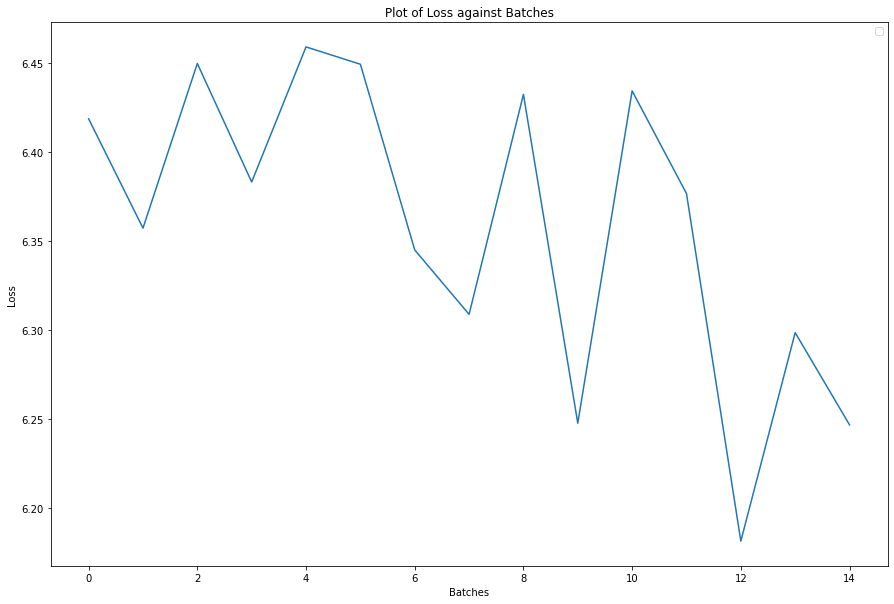

In [14]:
# Visualize training loss
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(loss_graph)), loss_graph)
plt.xlabel('Batches') 
plt.ylabel('Loss')
plt.legend()
plt.title('Plot of Loss against Batches')
plt.show()

We can also visualize how the different words/tokens are embedded by the embedding layer, i.e. what did the embedding layer learn without context?

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


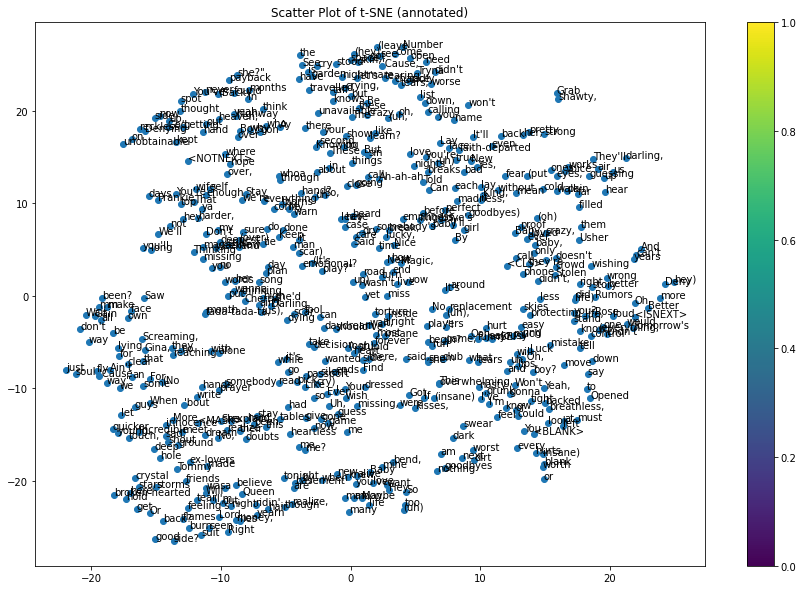

In [15]:
# TSNE on embedding layer
embedding_numpy = np.array(state["params"]["embed"]["embeddings"])
tsne = manifold.TSNE(n_components=2, random_state=42)
embedding_numpy = tsne.fit_transform(embedding_numpy)

plt.figure(figsize=(15,10))
plt.scatter(embedding_numpy[:,0], embedding_numpy[:,1], cmap='viridis')
for i in range(len(embedding_numpy)):
  plt.annotate(inv_map[i], (embedding_numpy[i][0], embedding_numpy[i][1]))
plt.colorbar()
plt.title("Scatter Plot of t-SNE (annotated)")
plt.show()

### 1(b)
Visualizing the attention plots

### 1(c)
Classification task on the NSP token.

Conclusion

### References:
1.   https://theaisummer.com/jax-transformer/
2.   https://github.com/deepmind/dm-haiku/blob/main/examples/transformer/train.py
3.   https://towardsdatascience.com/build-a-transformer-in-jax-from-scratch-how-to-write-and-train-your-own-models-9aa02b5b28fd